## SHAPIQ

Shapley Interaction Quantification (shapiq) is a Python package for 

1. approximating any-order Shapley interactions
2. benchmarking game-theoretical algorithms for machine learning
3. explaining feature interactions of model predictions. 

shapiq extends the well-known shap package for both researchers working on game theory in machine learning, as well as the end-users explaining models. SHAP-IQ extends individual Shapley values by quantifying the synergy effect between entities (aka players in the jargon of game theory) like explanatory features, data points, or weak learners in ensemble models. Synergies between players give a more comprehensive view of machine learning models.

In [1]:
import shapiq
import warnings
warnings.filterwarnings("ignore")

# load data
data = shapiq.load_california_housing()

In [2]:
X, y = data

In [3]:
X = X.drop(['Latitude', 'Longitude'], axis = 1).values
y = y.values

In [4]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    random_state = 42,
    n_estimators = 1000,
    criterion = 'squared_error',
    max_depth = 10,
    min_samples_split = 2,
    min_samples_leaf = 2
)
model.fit(X, y)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=1000,
                      random_state=42)

In [5]:
explainer = shapiq.TabularExplainer(
    model = model,
    data = X,
    index = 'k-SII',
    max_order = 4
)

In [6]:
interaction_values = explainer.explain(
    X[0], budget = 256
)
print(interaction_values)

InteractionValues(
    index=k-SII, max_order=4, min_order=0, estimated=False, estimation_budget=256,
    n_players=6, baseline_value=2.0677292762783623,
    Top 10 interactions:
        (0,): 2.2983475664012354
        (0, 2, 4, 5): 0.3790534334372136
        (4, 5): 0.34372213273562047
        (2, 4): 0.33804125931486423
        (1, 4): 0.3113792601927116
        (0, 1): 0.3049724581147847
        (0, 2, 4): -0.2540573579123204
        (4,): -0.27898832221339603
        (0, 4, 5): -0.34127749028416654
        (2, 4, 5): -0.4951541658007283
)


In [7]:
data[0].columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

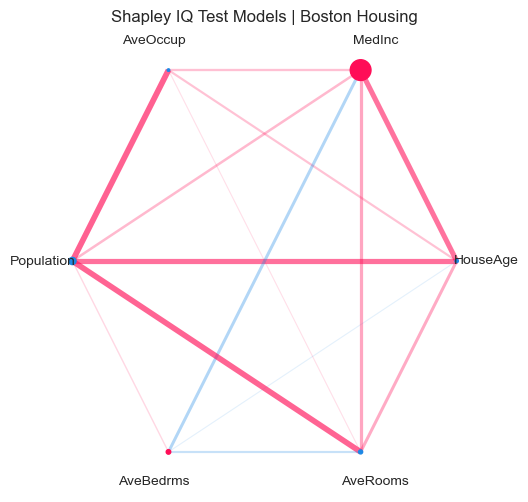

In [8]:
import matplotlib.pyplot as plt

fig, ax = shapiq.network_plot(
    first_order_values = interaction_values.get_n_order_values(1),
    second_order_values = interaction_values.get_n_order_values(2),
    feature_names = data[0].columns,
    draw_legend = False
)
ax.set_title('Shapley IQ Test Models | Boston Housing')
plt.show()

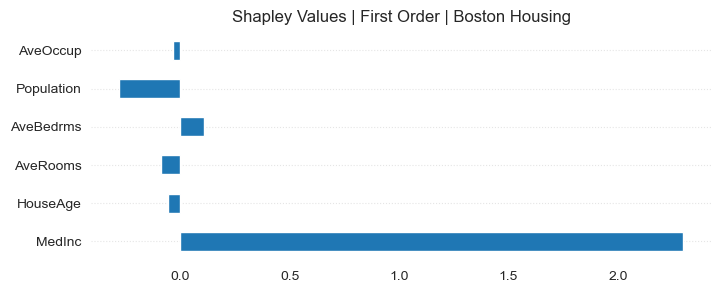

In [12]:
fig, ax = plt.subplots(figsize = (8, 3))
ax.barh(
    data[0].drop(['Latitude', 'Longitude'], axis = 1).columns,
    interaction_values.get_n_order_values(1),
    height = 0.5
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.set_title('Shapley Values | First Order | Boston Housing')
plt.show()

### Factor Models (FF15)

In [13]:
import pandas_datareader as pdr

ff15_model = pdr.get_data_famafrench(
    'F-F_Research_Data_5_Factors_2x3_daily',
    start = '1990-01-01'
)

In [14]:
ff15_model[0].head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1990-01-02,1.44,-0.67,-0.07,0.19,-0.44,0.026
1990-01-03,-0.06,0.72,-0.26,0.14,-0.43,0.026
1990-01-04,-0.71,0.44,-0.22,-0.06,-0.03,0.026
1990-01-05,-0.85,0.74,-0.21,-0.01,-0.12,0.026
1990-01-08,0.30,-0.40,-0.26,0.06,0.31,0.026


In [15]:
ff95_model = pdr.get_data_famafrench(
    'F-F_Momentum_Factor_daily',
    start = '1990-01-01'
)

In [16]:
import pandas as pd
import numpy as np

data = pd.concat(
    [ff15_model[0], ff95_model[0]],
    axis = 1
)

In [17]:
import yfinance as yf

price = yf.download(
    'AAPL',
    start = '1989-12-29',
    end = '2024-09-01',
    progress = False
)

In [18]:
aapl_ret = price['Close'].pct_change().dropna()
aapl_ret.name = 'return'

In [19]:
aapl_ret.head()

Date
1990-01-02    0.056737
1990-01-03    0.006711
1990-01-04    0.003336
1990-01-05    0.003322
1990-01-08    0.006622
Name: return, dtype: float64

In [20]:
data = data * 0.01

In [21]:
excess_return = aapl_ret - data['RF']
excess_return.name = 'excess_return'

In [22]:
data.drop(['RF'], axis = 1, inplace = True)

In [23]:
forest_model = RandomForestRegressor(
    random_state = 42,
    n_estimators = 1000,
    criterion = 'squared_error',
    max_depth = 10,
    min_samples_split = 2,
    min_samples_leaf = 2
)

In [24]:
forest_model.fit(
    data.values, 
    excess_return.values
)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=1000,
                      random_state=42)

In [25]:
explainer = shapiq.TabularExplainer(
    model = forest_model,
    data = data.values,
    index = 'k-SII',
    max_order = 4
)

In [26]:
interaction_values = explainer.explain(
    data.values[-1], budget = 256
)
print(interaction_values)

InteractionValues(
    index=k-SII, max_order=4, min_order=0, estimated=False, estimation_budget=256,
    n_players=6, baseline_value=0.0010140127824147338,
    Top 10 interactions:
        (0,): 0.009477354529157258
        (0, 2): 0.0035015631618816935
        (2, 3, 4, 5): 0.0025091179298360367
        (1, 5): 0.0018383471591335817
        (0, 1, 2): -0.001889804072300424
        (0, 2, 4, 5): -0.0021597598572398215
        (0, 1): -0.002242408714042171
        (1, 2, 5): -0.0022428010733512183
        (2, 3, 5): -0.0022910001063840084
        (0, 1, 5): -0.002298479418305822
)


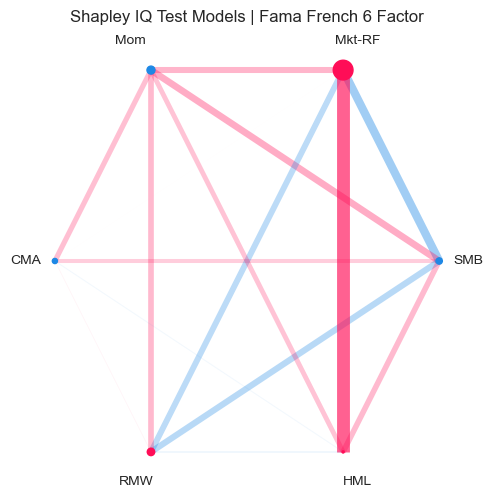

In [27]:
fig, ax = shapiq.network_plot(
    first_order_values = interaction_values.get_n_order_values(1),
    second_order_values = interaction_values.get_n_order_values(2),
    feature_names = data.columns,
    draw_legend = False
)
ax.set_title('Shapley IQ Test Models | Fama French 6 Factor')
plt.show()

**Insight** : 가장 최근에 초과수익률에 가장 큰 영향을 끼친 것은 Mkt-RF이다

### Causal Effect

Shapley 값을 통해 target과 variable간의 상관관계를 확인하면, Causal Effect도 확인해본다. 즉, insight는 shapley값을 통해 얻을 수 있고, 이를 인과관계로 발전시키는 방식을 사용한다.

#### Example : FF15 + MOM Model

Momentum Factor의 순수한 효과를 보기 위해서, 이중차감법을 이용해 추정해 보도록 한다

$$\text{MOM} = \alpha_0 + \alpha_1 r_m + \alpha_2 \text{HML} + \alpha_3 \text{SMB} + \alpha_4 \text{RMW} + \alpha_5 \text{CMA} + \tilde{\tau}$$
$$r_t = \beta_0 + \beta_1 r_m + \beta_2 \text{HML} + \beta_3 \text{SMB} + \beta_4 \text{RMW} + \beta_5 \text{CMA} + \tilde{\epsilon}$$

$$\tilde{\epsilon} = \gamma_0 + \gamma_1 \tilde{\tau} + u_t$$

여기서 $\gamma_1$은 Momentum 모형(Treatment Model)에서 다른 요인들이 Momentum 요인에서 설명하지 못한 변동 부분이 excess return 모형(Explain Model)에서 다른 요인들이 초과 수익의 변동을 설명하지 못하는 변동에 대해 얼마나 영향을 주는지에 대한 부분이다. 즉, 다른 조건이 모두 동일하다는 가정 하에 Momentum Factor가 Excess Return에 대해 얼마나 영향을 미치는지 보여준다.

In [28]:
import statsmodels.api as sm

controls = data[['Mkt-RF','HML','SMB','RMW','CMA']]
treatments = data['Mom   ']

treatment_model = sm.OLS(
    treatments, sm.add_constant(controls)
).fit()

print(treatment_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Mom      R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     430.0
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:49:58   Log-Likelihood:                 29361.
No. Observations:                8733   AIC:                        -5.871e+04
Df Residuals:                    8727   BIC:                        -5.867e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      9e-05      2.744      0.0

In [29]:
explain_model = sm.OLS(
    excess_return, sm.add_constant(controls)
).fit()

print(explain_model.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     671.4
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:50:00   Log-Likelihood:                 20615.
No. Observations:                8733   AIC:                        -4.122e+04
Df Residuals:                    8727   BIC:                        -4.118e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.923      0.0

In [30]:
t_tilde = treatment_model.resid # treatment models
y_tilde = explain_model.resid # excess return models 

t_tilde.name = 't_tilde'
y_tilde.name = 'y_tilde'

causal_model = sm.OLS(
    y_tilde, sm.add_constant(t_tilde)
).fit()

print(causal_model.summary())

                            OLS Regression Results                            
Dep. Variable:                y_tilde   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.350
Date:                Sun, 20 Oct 2024   Prob (F-statistic):              0.245
Time:                        21:50:00   Log-Likelihood:                 20616.
No. Observations:                8733   AIC:                        -4.123e+04
Df Residuals:                    8731   BIC:                        -4.121e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.069e-16      0.000  -2.89e-12      1.0

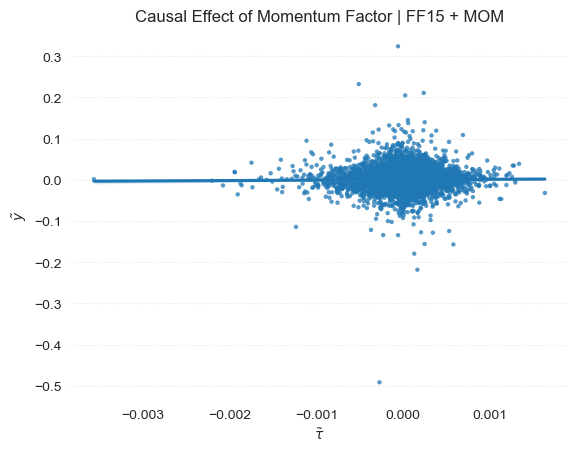

In [32]:
import seaborn as sns

fig ,ax = plt.subplots()
sns.regplot(
    x = causal_model.fittedvalues, 
    y = y_tilde, 
    scatter_kws = {'s' : 10, 'edgecolor' : 'None', 'marker' : '.', 'alpha' : 0.75},
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Causal Effect of Momentum Factor | FF15 + MOM')
plt.xlabel(r'$\tilde{\tau}$')
plt.ylabel(r'$\tilde{y}$')
plt.show()

### Causal Machine Learning

In [37]:
from econml.dml.causal_forest import CausalForestDML

causal_forest = CausalForestDML(
    model_y = RandomForestRegressor(
        random_state = 42,
        n_estimators = 1000,
        criterion = 'squared_error',
        max_depth = 10,
        min_samples_split = 2,
        min_samples_leaf = 2
    ),
    model_t = RandomForestRegressor(
        random_state = 42,
        n_estimators = 1000,
        criterion = 'squared_error',
        max_depth = 10,
        min_samples_split = 2,
        min_samples_leaf = 2
    ),
    random_state = 42,
    discrete_treatment = False
)
# fitting
causal_forest.fit(
    X = data[['Mkt-RF','HML','SMB','RMW','CMA']],
    T = data['Mom   '],
    Y = excess_return
)

In [38]:
treatment_effect_dml = causal_forest.effect(
    X = data[['Mkt-RF','HML','SMB','RMW','CMA']]
)

In [42]:
lb, ub = causal_forest.effect_interval(X = data[['Mkt-RF','HML','SMB','RMW','CMA']])

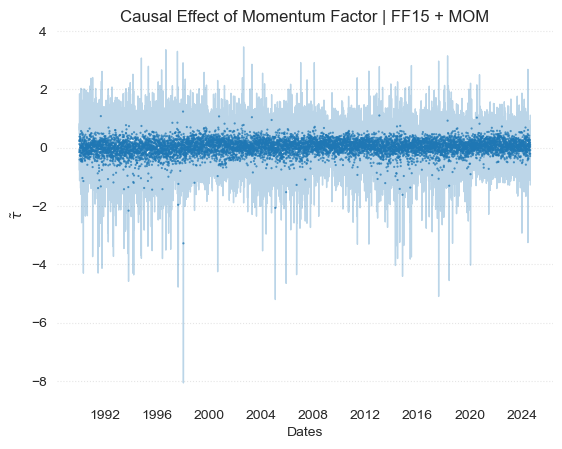

In [55]:
fig ,ax = plt.subplots()
ax.scatter(
    data.index, 
    treatment_effect_dml, 
    s = 10,
    marker = '.',
    edgecolor = 'None',
    alpha = 0.75
)
ax.plot(data.index, lb, color = 'tab:blue', alpha = 0.3, lw = 1)
ax.plot(data.index, ub, color = 'tab:blue', alpha = 0.3, lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Causal Effect of Momentum Factor | FF15 + MOM')
plt.xlabel(r'Dates')
plt.ylabel(r'$\tilde{\tau}$')
plt.show()